<a href="https://colab.research.google.com/github/ihatestudysomuch/pytorch/blob/main/Pytorch_28%EC%9E%A5_GRU%EB%A1%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch # pytorch
import numpy as np #
import pandas as pd # 시각화
from torch import nn # 모델
import matplotlib.pyplot as plt # 시각화 2
from sklearn.preprocessing import MinMaxScaler # Scaler로 값 조정
from torch.utils.data import TensorDataset, DataLoader # Data

In [2]:

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # 난 cpu

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")


using PyTorch version: 2.5.1+cu121, Device: cpu


In [3]:
FEATURE_NUMS = 4        # 입력층으로 들어가는 데이터 개수 feature
SEQ_LENGTH = 5          # 정답을 만들기 위해 필요한 시점 개수 time step
HIDDEN_SIZE = 4         # RNN 계열 계층을 구성하는 hidden state 개수
NUM_LAYERS = 1          # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3    # 학습율 lr
BATCH_SIZE = 20         # 학습을 위한 배치사이즈 개수

In [5]:
!pip install finance-datareader

In [6]:
import FinanceDataReader as fdr

df = fdr.DataReader('005930', '2020-01-01', '2024-06-30') # 삼성전자 주가 목록'005930', 2020-01-01 ~ 2024-06-30

df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ] # 장 오픈, 고점, 저점, 크기, 장 마감

df.head(10) # 상위 10개

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,55500,56000,55000,12993228,55200
2020-01-03,56000,56600,54900,15422255,55500
2020-01-06,54900,55600,54600,10278951,55500
2020-01-07,55700,56400,55600,10009778,55800
2020-01-08,56200,57400,55900,23501171,56800
2020-01-09,58400,58600,57400,24102579,58600
2020-01-10,58800,59700,58300,16000170,59500
2020-01-13,59600,60000,59100,11359139,60000
2020-01-14,60400,61000,59900,16906295,60000


In [7]:
split =   int(0.7 * len(df)) # train : test = 7 : 3

train_df = df[:split]
test_df = df[split:]

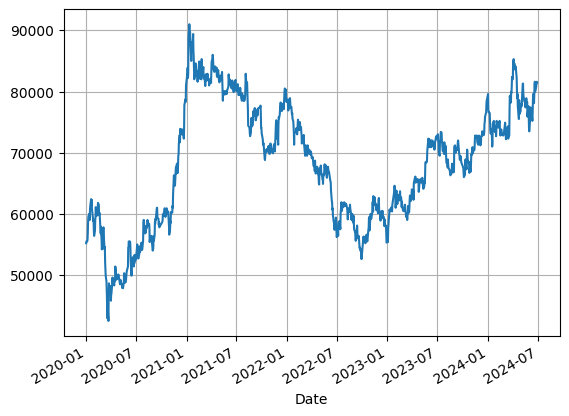

In [8]:
df['Close'].plot().grid() # label값 시각화

In [20]:
scaler_x = MinMaxScaler() # MinMaxScaler, 데이터 전처리를 위해 기본값 [0,1]로 변경
scaler_y = MinMaxScaler() # MinMaxScaler

train_df.iloc[ : , :-1 ] = scaler_x.fit_transform(train_df.iloc[ : , :-1 ])
test_df.iloc[ : , :-1 ] = scaler_x.fit_transform(test_df.iloc[ : , :-1 ])

train_df.iloc[ : , -1 ] = scaler_y.fit_transform(train_df.iloc[ : , [-1] ])
test_df.iloc[ : , -1 ] = scaler_y.fit_transform(test_df.iloc[ : , [-1]])

In [21]:
def MakeSeqNumpyData(data, seq_length):

    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i+seq_length, :-1 ]) # 행의 전체와 열의 마지막을 제외한 전체부분
        y_seq_list.append(data[ i+seq_length, [-1] ]) # 열의 마지막 부분

    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)

    return x_seq_numpy, y_seq_numpy

In [22]:
x_train, y_train = MakeSeqNumpyData(np.array(train_df), SEQ_LENGTH)
x_test, y_test = MakeSeqNumpyData(np.array(test_df), SEQ_LENGTH) # time_steps = 5

In [24]:
# 데이터 생성

x_train_tensor = torch.FloatTensor(x_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)

x_test_tensor = torch.FloatTensor(x_test).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test).to(DEVICE)

# dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# dataloader
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)



In [25]:
# 모델 정의
class MyGRUModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # GRU
        self.fc = nn.Linear(hidden_size, 1) # 출력값 1개

    # 피드 포워드
    def forward(self, data):
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)

        outputs, _ = self.gru(data, h0)
        last_hs = outputs[:, -1, :] # [input_size, hidden_size, num_layers]에서 전체 input_size, 마지막 hidden_size, num_layers를 출력
        prediction = self.fc(last_hs)

        return prediction


In [26]:
# 손실함수, 옵티마이저
model = MyGRUModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE) # 4 4 1

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train() # 학습모드

    train_loss_sum = 0

    total_train_batch = len(dataloader)

    for inputs, labels in dataloader:

        x_train = inputs.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train) # 예측값
        loss = loss_function(outputs, y_train) # 오차

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

    train_avg_loss = train_loss_sum / total_train_batch

    return train_avg_loss

In [27]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval() # 평가모드

    with torch.no_grad():

        val_loss_sum = 0

        total_val_batch = len(dataloader)

        for inputs, labels in dataloader:

            x_val = inputs.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            # 역전파 코드 없음

            val_loss_sum += loss.item()

        val_avg_loss = val_loss_sum / total_val_batch

    return val_avg_loss

In [29]:
# 학습
from datetime import datetime

train_loss_list = []

start_time = datetime.now()

EPOCHS = 200

for epoch in range(EPOCHS):

    avg_loss = model_train(train_dataloader, model, loss_function, optimizer)

    train_loss_list.append(avg_loss)

    if (epoch % 10 == 0):
        print('epoch: ', epoch, ', train loss = ', avg_loss)

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)


epoch:  0 , train loss =  0.016723427480498616
epoch:  10 , train loss =  0.0008929474693454372
epoch:  20 , train loss =  0.000830440197322064
epoch:  30 , train loss =  0.0008229904715568783
epoch:  40 , train loss =  0.000826358859716819
epoch:  50 , train loss =  0.0008211399668093341
epoch:  60 , train loss =  0.000807785001084901
epoch:  70 , train loss =  0.0007913724455134704
epoch:  80 , train loss =  0.0007743853650306567
epoch:  90 , train loss =  0.0007577174382720095
epoch:  100 , train loss =  0.0007418798333487641
epoch:  110 , train loss =  0.0007272697182951304
epoch:  120 , train loss =  0.0007142696409480264
epoch:  130 , train loss =  0.0007031646084028464
epoch:  140 , train loss =  0.0006940428269071839
epoch:  150 , train loss =  0.0006867457231214175
epoch:  160 , train loss =  0.0006809563533468649
epoch:  170 , train loss =  0.0006762869146395809
epoch:  180 , train loss =  0.000672399491752283
epoch:  190 , train loss =  0.0006690372321874094
elapsed time => 

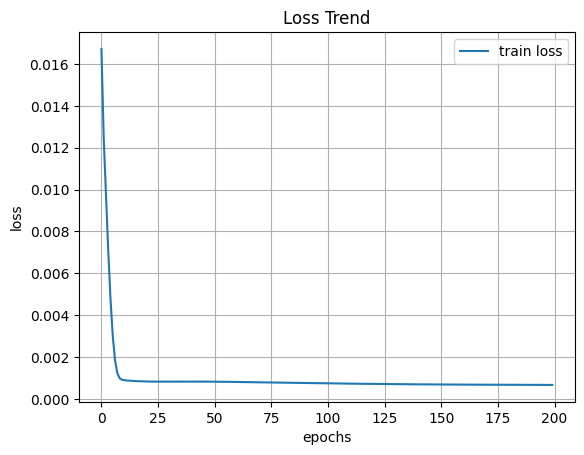

In [30]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train loss')
plt.legend()
plt.show()

In [32]:
# test
test_pred_tensor = model(x_test_tensor)

test_pred_numpy = test_pred_tensor.cpu().detach().numpy() # 역전파 방지를 위해 더이상 계산, 그래프에 넣지 않음

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy) # 원가로 보여주기 위해 inverse_transform

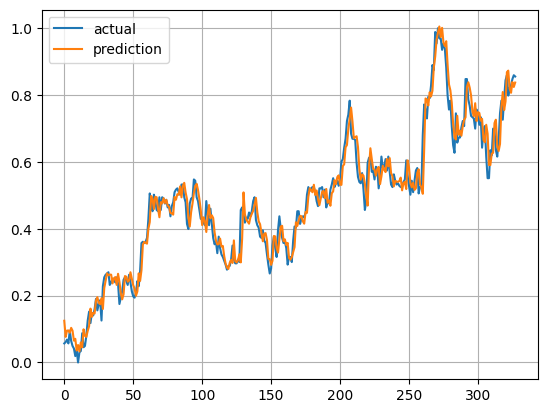

In [33]:
import matplotlib.pyplot as plt

plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

plt.show()
